# Exploring & Processing Data

In this jupyter notebook we will explore the datasets used for our project. We will primarily focus on 

In [86]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import xyzservices.providers as xyz
from census import Census

import os

from shapely.geometry import Point, Polygon

# Loading environment variables
from dotenv import load_dotenv
load_dotenv()
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

## 311 Cases in 2023

Below is the raw table of all 311 service requests opened in 2023.

In [87]:
serv_req_df = pd.read_csv("data/raw/311_Cases_2023.csv")

Let's do a quick analysis of what this dataset consists of.

In [88]:
serv_req_df.sample(5)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Police District,Latitude,Longitude,Point,point_geom,Source,Media URL,BOS_2012,data_as_of,data_loaded_at
831720,16525261,03/10/2023 04:13:00 AM,03/11/2023 07:34:00 AM,03/11/2023 07:34:00 AM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,...,MISSION,0.000000,0.000000,"(0.0, 0.0)",POINT (0 0),Phone,NaN,9.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
769761,17312102,09/18/2023 06:58:00 AM,09/18/2023 07:09:43 AM,09/18/2023 07:09:43 AM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,...,MISSION,37.762355,-122.420123,"(37.76235477, -122.42012319)",POINT (-122.420123188 37.762354773),Mobile/Open311,NaN,9.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
337522,17593614,11/26/2023 05:34:00 PM,11/26/2023 05:45:39 PM,11/26/2023 05:45:39 PM,Closed,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Blocking_Driveway_Cite_Only,White - Lexus rx350 - 1 omkar,...,NORTHERN,37.799477,-122.431778,"(37.799477, -122.431778)",POINT (-122.431778 37.799477),Web,https://mobile311.sfgov.org/media/san_francisc...,NaN,2024/04/10 10:23:00 AM,2024/09/11 05:09:50 PM
648482,16672484,04/14/2023 04:38:06 PM,04/15/2023 11:09:18 AM,04/15/2023 11:09:18 AM,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,...,TARAVAL,37.763364,-122.483706,"(37.76336357, -122.48370565)",POINT (-122.483705655 37.763363575),Mobile/Open311,NaN,4.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
685015,16349974,01/26/2023 06:27:00 AM,01/26/2023 09:20:53 AM,01/26/2023 09:20:53 AM,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,...,INGLESIDE,37.739948,-122.427029,"(37.739948, -122.427029)",POINT (-122.427029 37.739948),Mobile/Open311,NaN,8.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM


In [89]:
print(serv_req_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840206 entries, 0 to 840205
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CaseID                 840206 non-null  int64  
 1   Opened                 840206 non-null  object 
 2   Closed                 808740 non-null  object 
 3   Updated                840206 non-null  object 
 4   Status                 840206 non-null  object 
 5   Status Notes           835836 non-null  object 
 6   Responsible Agency     840206 non-null  object 
 7   Category               840206 non-null  object 
 8   Request Type           840206 non-null  object 
 9   Request Details        831141 non-null  object 
 10  Address                840206 non-null  object 
 11  Street                 830788 non-null  object 
 12  Supervisor District    830788 non-null  float64
 13  Neighborhood           830704 non-null  object 
 14  Analysis Neighborhood  732571 non-nu

## Cleaning the Service Requests DataFrame

### Initial Cleanup

In [90]:
# Selecting useful columns
useful_cols = [
    'CaseID', 'Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
    'Responsible Agency', 'Category', 'Request Type', 'Request Details',
    'Neighborhood', 'Analysis Neighborhood', 'Police District',
    'Latitude', 'Longitude', 'Source'
]

serv_req_df = serv_req_df[useful_cols].copy()

# Removing duplicates and filtering by SF bounding box
serv_req_df.drop_duplicates(subset='CaseID', inplace=True)
serv_req_df = serv_req_df[
    serv_req_df['Latitude'].between(37.6, 37.9) &
    serv_req_df['Longitude'].between(-123.2, -122.3)
]

# Simplifying column names
serv_req_df.columns = (
    serv_req_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

print("DataFrame snippet so far:\n")
display(serv_req_df.sample(3))

DataFrame snippet so far:



,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,neighborhood,analysis_neighborhood,police_district,latitude,longitude,source
709209,17407319,10/10/2023 09:14:38 PM,10/11/2023 01:08:56 PM,10/11/2023 01:08:56 PM,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,South of Market,Financial District/South Beach,SOUTHERN,37.790919,-122.396248,Mobile/Open311
299295,16588492,03/25/2023 08:34:00 AM,03/25/2023 09:24:33 PM,03/25/2023 09:24:33 PM,Closed,Removed - Case Resolved - TLCBD clean team has...,Tenderloin CBD Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Tenderloin,Tenderloin,TENDERLOIN,37.785227,-122.415897,Web
691973,17263988,09/06/2023 01:14:00 PM,NaN,09/07/2023 07:58:20 PM,Open,open,Muni Feedback Received Queue,Muni Service Feedback,Muni - Complaint_Maintenance_Repair,Vehicle_Maintenance_Noise,Civic Center,Hayes Valley,SOUTHERN,37.775130,-122.419668,Mobile/Open311


### Categorizing Categoricals

We're just marking a column if they're a categorical or not.

In [91]:
cat_cols = [
    'status',
    'status_notes',
    'responsible_agency',
    'category',
    'request_type',
    'request_details',
    'neighborhood',
    'analysis_neighborhood',
    'police_district',
    'source'
]

for col in cat_cols:
    if col in serv_req_df.columns:
        serv_req_df[col] = (
            serv_req_df[col]
            .astype('string')                      # efficient string dtype
            .str.strip()                           # remove leading/trailing spaces
            .str.replace(r'\s+', ' ', regex=True)  # collapse multiple spaces
            .str.replace('_', ' ', regex=False)    # underscores → spaces
            .str.title()                           # nice display casing
        )

### Temporal Cleanup

In [92]:
# Properly format date columns
date_cols = ['opened', 'closed', 'updated']
for col in date_cols:
    serv_req_df[col] = pd.to_datetime(
        serv_req_df[col],
        format='%m/%d/%Y %I:%M:%S %p',
        errors='coerce'
    )
    
# Deriving new temporal columns
serv_req_df['year'] = serv_req_df['opened'].dt.year.astype('Int16')
serv_req_df['month'] = serv_req_df['opened'].dt.month.astype('Int8')
serv_req_df['dow'] = serv_req_df['opened'].dt.day_name()
serv_req_df['hour'] = serv_req_df['opened'].dt.hour.astype('Int8')
serv_req_df['request_duration_hrs'] = (
    (serv_req_df['closed'] - serv_req_df['opened'])
    .dt.total_seconds() / 3600
)

### Spatial Cleanup

In [93]:
serv_req_gdf = gpd.GeoDataFrame(
    serv_req_df,
    geometry=gpd.points_from_xy(serv_req_df.longitude, serv_req_df.latitude),
    crs='EPSG:4326'
)

### Some final touches

Some final touches to make sure each column is the right data type.

In [94]:
serv_req_gdf['neighborhood'] = (
    serv_req_gdf['analysis_neighborhood']
    .fillna(serv_req_gdf['neighborhood'])
    .str.strip()
    .str.title()
)
serv_req_gdf.drop(columns=['analysis_neighborhood'], inplace=True)

serv_req_gdf['category'] = serv_req_gdf['category'].str.title().str.strip()
serv_req_gdf['responsible_agency'] = serv_req_gdf['responsible_agency'].str.replace('_', ' ').str.title()

serv_req_gdf['is_closed'] = serv_req_gdf['status'].eq('Closed').astype('bool')

bins = [0, 1, 24, 72, np.inf]
labels = ['<1hr', '1–24hr', '1–3days', '>3days']
serv_req_gdf['response_time_cat'] = pd.cut(
    serv_req_gdf['request_duration_hrs'], bins=bins, labels=labels
)

# A preview of the cleaned GeoDataFrame
display(serv_req_gdf.sample(3))
print("Updated column data types:\n", \
    serv_req_gdf.dtypes)

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,longitude,source,year,month,dow,hour,request_duration_hrs,geometry,is_closed,response_time_cat
675033,15973543,2022-10-19 10:39:00,2023-11-21 12:59:16,2023-11-21 12:59:16,Closed,Case Resolved,Dpw Ops Queue,Graffiti,Graffiti On Building Commercial,Building Commercial - Offensive,...,-122.482055,Web,2022,10,Wednesday,10,9554.337778,POINT (-122.48205 37.78048),True,>3days
465897,16621529,2023-04-02 19:31:00,2023-09-22 02:00:01,2023-09-22 02:00:01,Closed,Case Resolved - As Part Of The Unprecedented C...,Dpw Ops Queue,Graffiti,Graffiti On Building Residential,Building Residential - Not Offensive,...,-122.429170,Mobile/Open311,2023,4,Sunday,19,4134.483611,POINT (-122.42917 37.78856),True,>3days
121785,16468533,2023-02-24 08:47:08,2023-02-25 11:31:00,2023-02-25 11:31:00,Closed,Case Resolved,Dpw Ops Queue,Sewer Issues,Flooding,On Street,...,-122.419065,Mobile/Open311,2023,2,Friday,8,26.731111,POINT (-122.41907 37.75863),True,1–3days


Updated column data types:
 caseid                           int64
opened                  datetime64[ns]
closed                  datetime64[ns]
updated                 datetime64[ns]
status                  string[python]
status_notes            string[python]
responsible_agency      string[python]
category                string[python]
request_type            string[python]
request_details         string[python]
neighborhood            string[python]
police_district         string[python]
latitude                       float64
longitude                      float64
source                  string[python]
year                             Int16
month                             Int8
dow                             object
hour                              Int8
request_duration_hrs           float64
geometry                      geometry
is_closed                         bool
response_time_cat             category
dtype: object


### Simple Plot

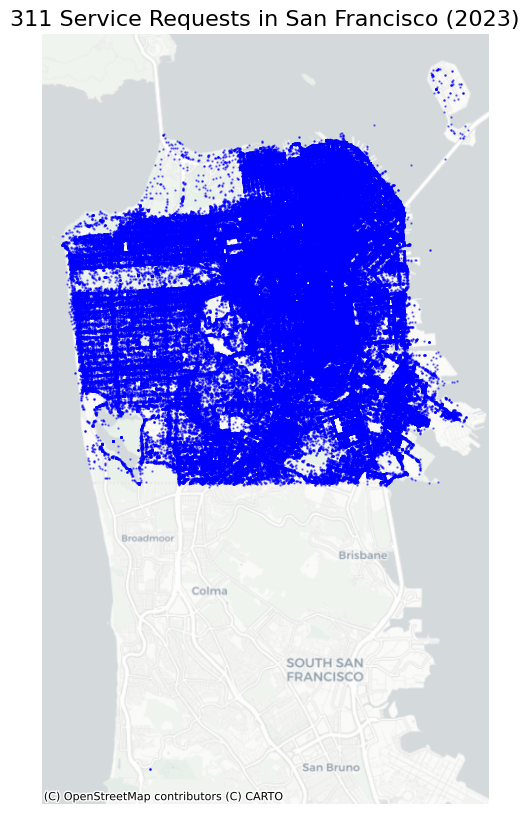

In [95]:
# Plot a simple visualization of the points
fig, ax = plt.subplots(figsize=(10, 10))
serv_req_gdf.plot(ax=ax, markersize=0.5, color='blue', alpha=0.5)
ax.set_title("311 Service Requests in San Francisco (2023)", fontsize=16)
# Overlay a basemap for context (optional)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=serv_req_gdf.crs)    
ax.axis('off')
plt.show()


### Quick Dashboard Describing Data

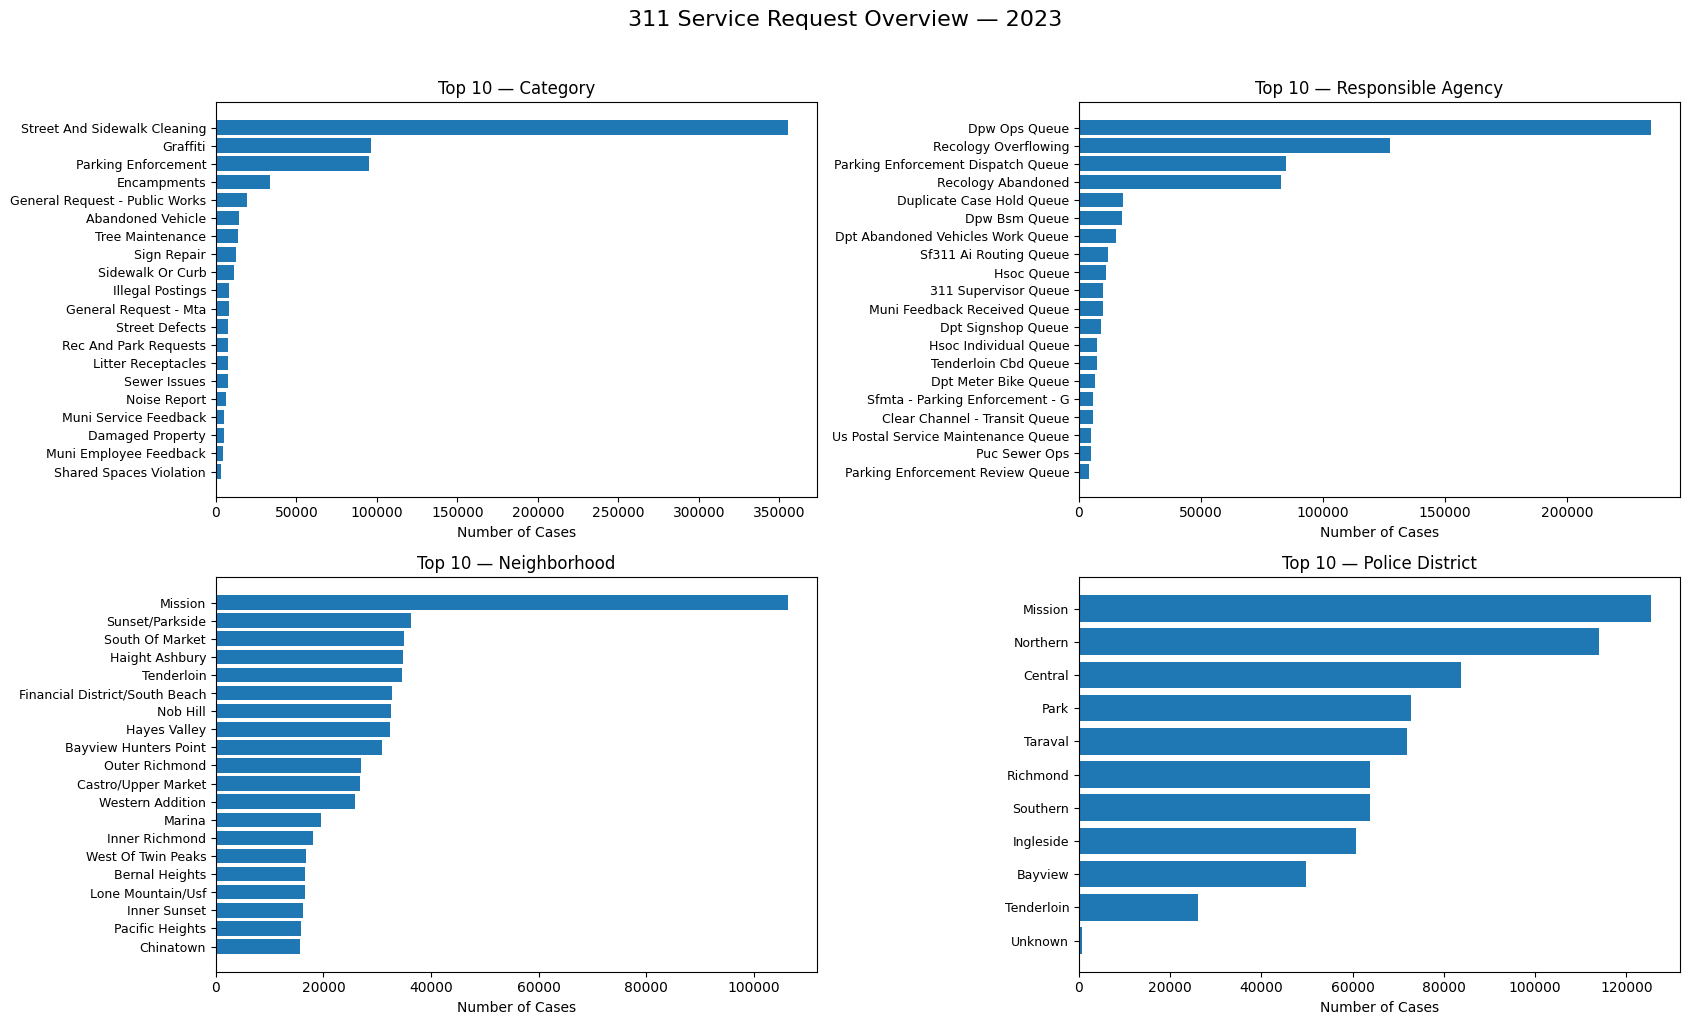

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))
axes = axes.flatten()

cat_info = [
    ('category', 'Top 10 — Category'),
    ('responsible_agency', 'Top 10 — Responsible Agency'),
    ('neighborhood', 'Top 10 — Neighborhood'),
    ('police_district', 'Top 10 — Police District'),
]

for ax, (col, title) in zip(axes, cat_info):
    if col in serv_req_gdf.columns:
        vc = (
            serv_req_gdf[col]
            .fillna('Unknown')
            .value_counts()
            .nlargest(20)
            .sort_values()
        )
        ax.barh(vc.index, vc.values)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Number of Cases")
        ax.tick_params(axis='y', labelsize=9)
    else:
        ax.text(0.5, 0.5, f"{col} not found", ha='center', va='center')
        ax.set_axis_off()

plt.suptitle("311 Service Request Overview — 2023", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

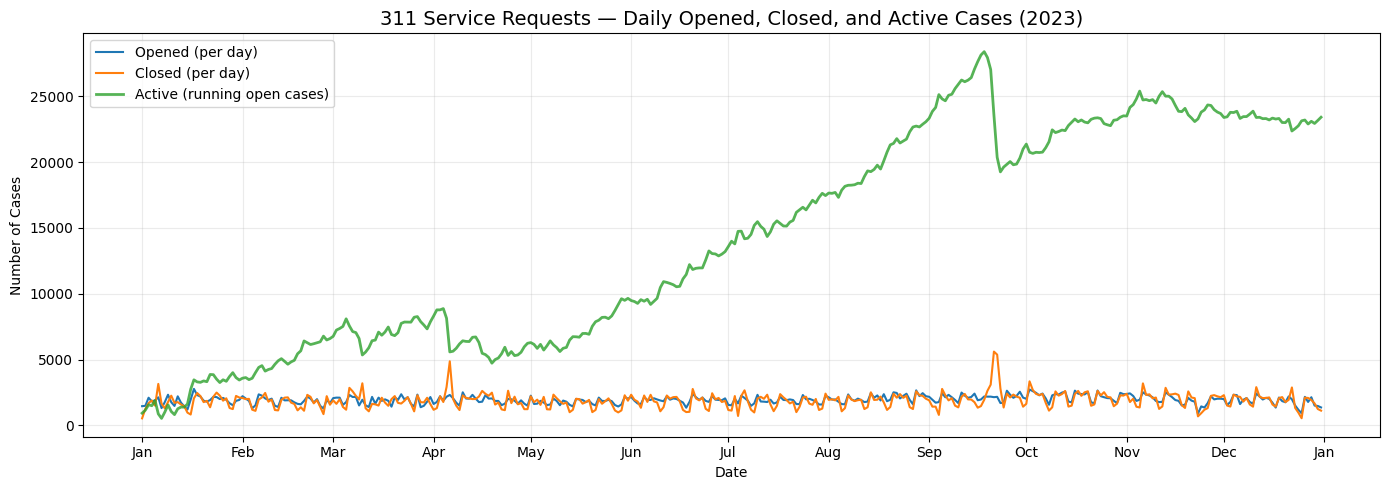

In [97]:
import matplotlib.dates as mdates

# Ensure datetime and filter to 2023
df = serv_req_gdf.copy()
df['opened'] = pd.to_datetime(df['opened'], errors='coerce')
df['closed'] = pd.to_datetime(df['closed'], errors='coerce')

df_2023 = df[
    (df['opened'].dt.year == 2023) | (df['closed'].dt.year == 2023)
].copy()

# daily opened/closed counts
df_2023['open_day'] = df_2023['opened'].dt.floor('D')
df_2023['close_day'] = df_2023['closed'].dt.floor('D')

opened_daily = df_2023.groupby('open_day').size().sort_index()
closed_daily = df_2023.groupby('close_day').size().sort_index()

# continuous date index for all days of 2023
all_days = pd.date_range('2023-01-01', '2023-12-31', freq='D')
opened_daily = opened_daily.reindex(all_days, fill_value=0)
closed_daily = closed_daily.reindex(all_days, fill_value=0)

# cumulative sums
opened_cum = opened_daily.cumsum()
closed_cum = closed_daily.cumsum()

# active backlog = cumulative opened - cumulative closed
active_daily = opened_cum - closed_cum

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(all_days, opened_daily, label='Opened (per day)', linewidth=1.5)
ax.plot(all_days, closed_daily, label='Closed (per day)', linewidth=1.5)
ax.plot(all_days, active_daily, label='Active (running open cases)', linewidth=2, alpha=0.8)

ax.set_title("311 Service Requests — Daily Opened, Closed, and Active Cases (2023)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Number of Cases")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.legend()
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()



### Caching DataFrame

This helps having to re-run the notebook the cleaning on each notebook boot.

In [98]:
serv_req_gdf.to_parquet('data/processed/serv_req_cleaned.parquet', index=False)

## Census ACS Data

In [99]:
# Pull ACS tract data for San Francisco County (FIPS 075), 2023 5-year ACS
sfCountyTracts_raw = census_data.acs5.state_county_tract(
    fields=(
        'NAME',
        'B01003_001E',  # total population
        'B19013_001E',  # median household income
        'B17001_001E',  # poverty universe
        'B17001_002E',  # below poverty
        'B19083_001E',  # Gini index
        'B25077_001E',  # median home value
        'B25064_001E',  # median rent
        'B25003_002E',  # owner-occupied units
        'B25003_003E',  # renter-occupied units
        'B15003_022E',  # bachelor's degree
        'B15003_023E',  # master's degree
        'B15003_025E',  # doctorate degree
        'B15003_001E',  # total population 25+ (education base)
        'B08301_010E',  # commute: drove alone
        'B08301_018E',  # commute: public transit
        'B08301_021E',  # commute: work from home
        'B03002_003E',  # white alone, not Hispanic
        'B03002_004E',  # Black or African American alone
        'B03002_006E',  # Asian alone
        'B03002_012E',  # Hispanic / Latino (any race)

    ),
    state_fips='06',
    county_fips='075',
    tract='*',
    year=2023
)

# convert to DataFrame
sfCountyTracts = pd.DataFrame(sfCountyTracts_raw)

### Calculating Useful Statistics

In [100]:
# Poverty rate
sfCountyTracts['poverty_rate'] = (
    sfCountyTracts['B17001_002E'] /
    sfCountyTracts['B17001_001E']
)

# % with bachelor's or higher (bachelor's + master's + doctorate)
sfCountyTracts['bachelors_plus_rate'] = (
    sfCountyTracts['B15003_022E'] +
    sfCountyTracts['B15003_023E'] +
    sfCountyTracts['B15003_025E']
) / sfCountyTracts['B15003_001E']

# % renter-occupied
sfCountyTracts['pct_renter_occupied'] = (
    sfCountyTracts['B25003_003E'] /
    (sfCountyTracts['B25003_002E'] + sfCountyTracts['B25003_003E'])
)

# Race shares
race_total = (
    sfCountyTracts['B03002_003E'] +  # white
    sfCountyTracts['B03002_004E'] +  # Black
    sfCountyTracts['B03002_006E'] +  # Asian
    sfCountyTracts['B03002_012E']    # Hispanic/Latino
)
sfCountyTracts['share_white']   = sfCountyTracts['B03002_003E'] / race_total
sfCountyTracts['share_black']   = sfCountyTracts['B03002_004E'] / race_total
sfCountyTracts['share_asian']   = sfCountyTracts['B03002_006E'] / race_total
sfCountyTracts['share_hispanic']= sfCountyTracts['B03002_012E'] / race_total

# Build a tract GEOID we can merge on later
sfCountyTracts['GEOID'] = (
    sfCountyTracts['state'] +
    sfCountyTracts['county'] +
    sfCountyTracts['tract']
)

In [101]:
# Rename columns to something readable for plotting/joins
acs_var_map = {
    'NAME': 'tract_name',
    'B01003_001E': 'total_population',
    'B19013_001E': 'median_household_income',
    'B17001_001E': 'poverty_universe',
    'B17001_002E': 'below_poverty_count',
    'B19083_001E': 'gini_index',
    'B25077_001E': 'median_home_value',
    'B25064_001E': 'median_rent',
    'B25003_002E': 'owner_occupied_units',
    'B25003_003E': 'renter_occupied_units',
    'B15003_022E': 'bachelors_count',
    'B15003_023E': 'masters_count',
    'B15003_025E': 'doctorate_count',
    'B15003_001E': 'education_base_25plus',
    'B08301_010E': 'workers_drive_alone',
    'B08301_018E': 'workers_public_transit',
    'B08301_021E': 'workers_work_from_home',
    'B03002_003E': 'white_alone',
    'B03002_004E': 'black_alone',
    'B03002_006E': 'asian_alone',
    'B03002_012E': 'hispanic_any_race',
}

sfCountyTracts.rename(columns=acs_var_map, inplace=True)

### Merging with Geodata Tract Information

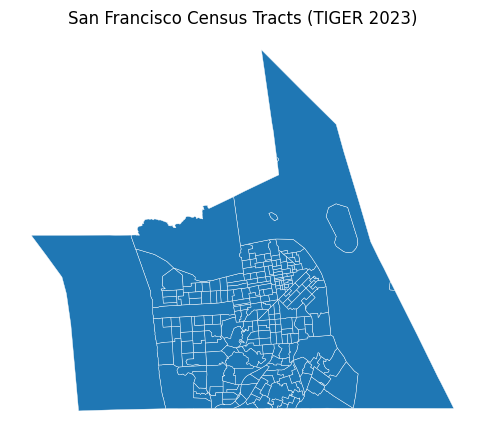

CRS: EPSG:4326
Number of tracts: 243


In [113]:
# Load ALL California tracts from TIGER 2023
ca_tracts = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_06_tract.zip"
)

# Filter to San Francisco County (just to ensure)
sf_tracts = ca_tracts.loc[ca_tracts["COUNTYFP"] == "075"].copy()

# Reproject to match your 311 GeoDataFrame's CRS 
sf_tracts = sf_tracts.to_crs(serv_req_gdf.crs)

# remove offshore Farallon Island tracts (population = 0)
sf_tracts = sf_tracts.cx[-122.6:-122.3, 37.6:37.9].copy()

# Quick plot to confirm
fig, ax = plt.subplots(figsize=(6,6))
sf_tracts.plot(ax=ax, edgecolor="white", linewidth=0.3)
ax.set_title("San Francisco Census Tracts (TIGER 2023)")
ax.set_axis_off()
plt.show()

# Sanity check
print(f"CRS: {sf_tracts.crs}")
print(f"Number of tracts: {len(sf_tracts)}")# Filter just San Francisco County (county FIPS "075")
sf_tracts = ca_tracts[ca_tracts["COUNTYFP"] == "075"].copy()

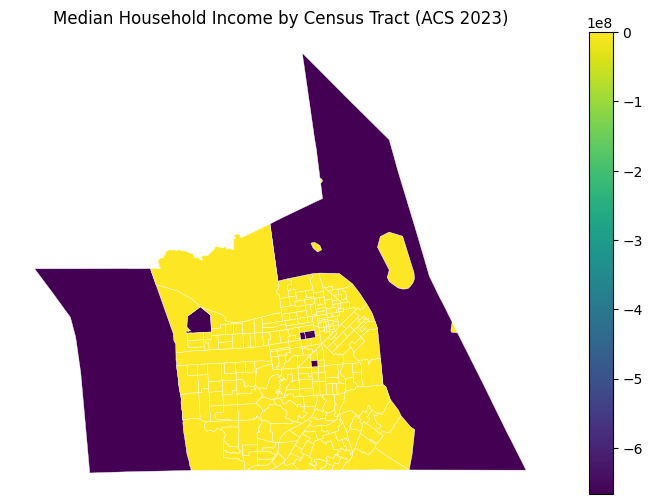

In [115]:
sf_tracts_acs = sf_tracts.merge(
    sfCountyTracts,
    left_on='GEOID',
    right_on='GEOID',
    how='left'
).cx[-122.6:-122.3, 37.6:37.9].copy()

fig, ax = plt.subplots(figsize=(10,6))
sf_tracts_acs.plot(
    ax=ax,
    column='median_household_income',
    legend=True,
    edgecolor='white',
    linewidth=0.3
)
ax.set_title("Median Household Income by Census Tract (ACS 2023)")
ax.set_axis_off()
plt.show()